# Vary $n_i$, $k_i$ and $d_i$ for a thin single layer sample

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractor, gen_loss_function
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from tqdm import tqdm
from itertools import product

Length of pulse array: 701
Bias: -0.18446526495726498


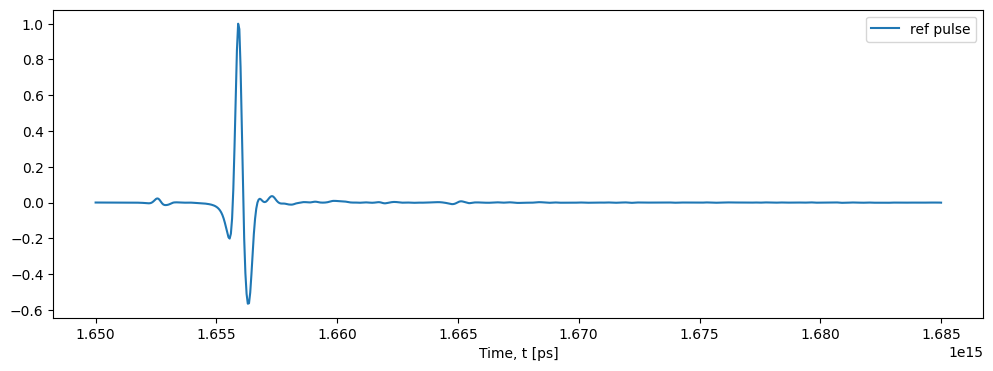

In [2]:
ref_path = 'data/example_ref_pulse.csv'
ref_df = pd.read_csv(ref_path)
t_axis = ref_df['Time_abs/ps'].to_numpy()
reference_pulse = ref_df[' Signal/nA'].to_numpy()

## Remove Dc bias
halfway = len(reference_pulse) // 2
# Calculate the mean of the second half (assumed baseline)
bias = np.mean(reference_pulse[halfway:])
# Subtract the bias from the entire signal
reference_pulse = reference_pulse - bias

# Normalize reference pulse
peak_val_ref = max(reference_pulse)
reference_pulse = reference_pulse / peak_val_ref

# Find signal length (in num points)
L = len(reference_pulse)
print(f'Length of pulse array: {L}')

print(f'Bias: {bias}')
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='ref pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [3]:
## Check time steps are consistent in t_axis

# Compute time differences between consecutive samples
dt = np.diff(t_axis)

# Check for uniform time step (within a small tolerance)
tolerance = 0.5e-12  # adjust as needed based on your signal's precision
is_uniform = np.all(np.abs(dt - dt[0]) < tolerance)

print("Time steps are uniform:", is_uniform)
if is_uniform:
    deltat = dt[0]
    print(f'delta_t: {deltat} ps')
if not is_uniform:
    print("Min dt:", np.min(dt))
    print("Max dt:", np.max(dt))
    print("Mean dt:", np.mean(dt))

Time steps are uniform: True
delta_t: 0.049999999999954525 ps


[((3.46-0.001j), 0.0001)]


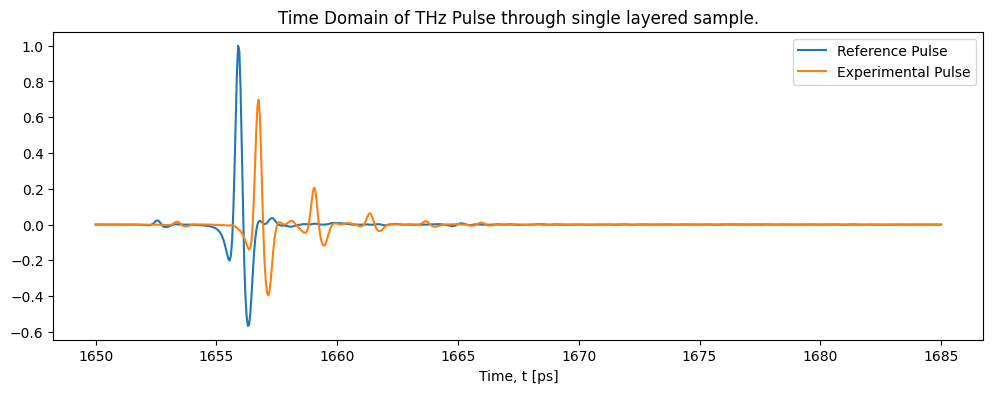

In [4]:
# Convert refence pulse to tensor
reference_pulse = torch.tensor(reference_pulse, dtype=torch.float32)

# Convert delta_t to seconds from pico seconds
deltat = deltat * 1e-12

# Material params
n1, k1, d1 = 3.46, -0.001, 0.1e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1)]

# Simulate the experimental data
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]


print(material_params_exp)
plt.figure(figsize=(12,4))
plt.title('Time Domain of THz Pulse through single layered sample.')
plt.plot(t_axis, reference_pulse, label='Reference Pulse')
plt.plot(t_axis, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

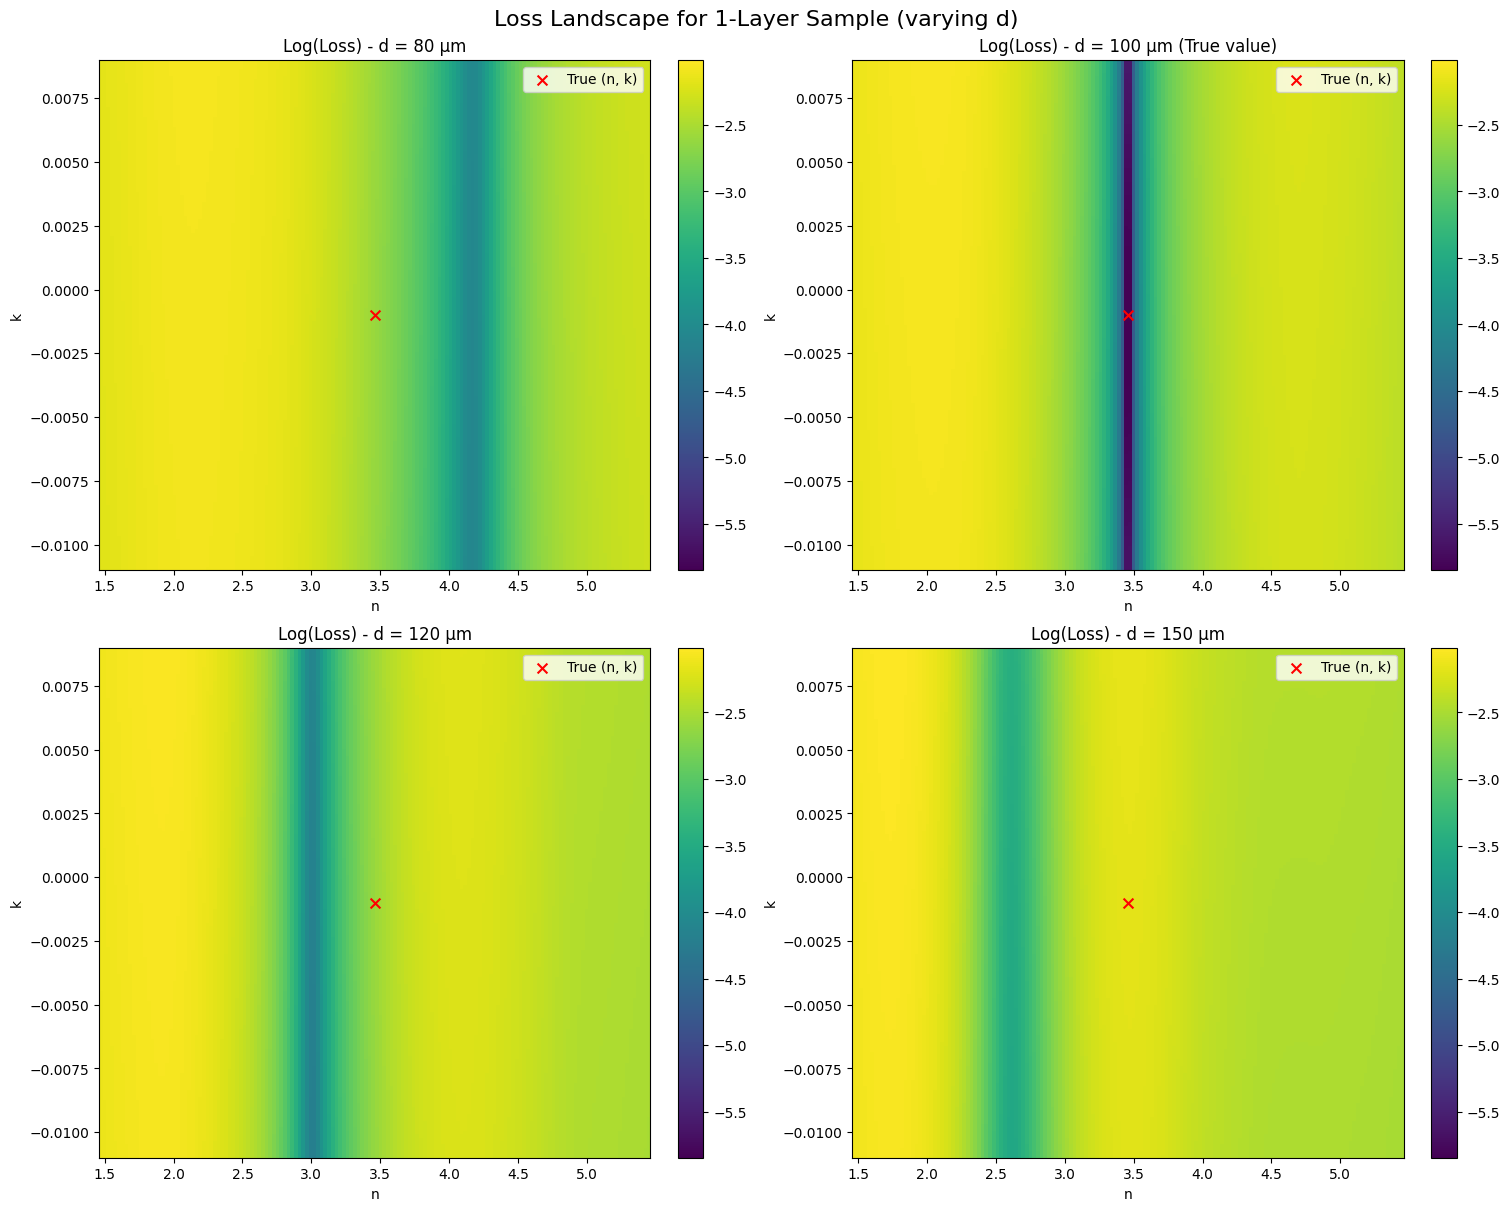

In [26]:
# Define resolution and grids

num_points_2d = 150
n_vals = np.linspace(n1 - 2, n1 + 2, num_points_2d)

k_vals = np.linspace(k1 - 0.01, k1 + 0.01, num_points_2d)
n_grid, k_grid = np.meshgrid(n_vals, k_vals)

#d_vals_microns = [85, 90, 95, 100, 105, 110]
#d_vals_microns = [50, 80, 100, 120, 150, 200]
d_vals_microns = [80, 100, 120, 150]

d_vals = [d_val * 1e-6 for d_val in d_vals_microns]

loss_fn = gen_loss_function

loss_grids = []

# Loop over fixed thicknesses
for d_fixed in d_vals:
    loss_grid_2d = np.zeros_like(n_grid)

    for i, j in tqdm(product(range(num_points_2d), repeat=2),
                     desc=f"d={d_fixed * 1e6:.1f} µm", leave=False):
        n_curr = n_grid[i, j]
        k_curr = k_grid[i, j]

        layer = [(n_curr + 1j * k_curr, d_fixed)]
        y_sim = simulate_parallel(reference_pulse, layer, deltat, noise_level=0)[1][:len(reference_pulse)]
        y_sim_tensor = y_sim.clone().detach()

        loss = loss_fn(y_sim_tensor, experimental_pulse).item()
        loss_grid_2d[i, j] = loss

    loss_grids.append(np.log(loss_grid_2d))
    #loss_grids.append(loss_grid_2d) # for non logged loss

# Compute color scale limits
all_losses_log = np.stack(loss_grids)
vmin, vmax = all_losses_log.min(), all_losses_log.max()

# Plotting
fig, axs = plt.subplots(2, int(len(d_vals_microns)/2), figsize=(15, 12), constrained_layout=True)
axs = axs.flatten()

for idx, (d_fixed_micron, loss_log) in enumerate(zip(d_vals_microns, loss_grids)):
    ax = axs[idx]
    
    im = ax.imshow(
        loss_log,
        extent=[n_vals[0], n_vals[-1], k_vals[0], k_vals[-1]],
        origin='lower',
        aspect='auto',
        cmap='viridis',
        vmin=vmin,
        vmax=vmax
    )
    
    # Check if this is the true thickness (allow for small floating point error)
    is_true_d = np.isclose(d_fixed_micron, d1 * 1e6, atol=1e-2)
    
    title = f"Log(Loss) - d = {d_fixed_micron} µm"
    if is_true_d:
        title += " (True value)"
    ax.set_title(title)

    ax.set_xlabel("n")
    ax.set_ylabel("k")
    
    # Plot true (n1, k1) as a red dot
    ax.scatter(n1, k1, color='red', marker='x', s=50, label='True (n, k)')
    ax.legend(loc='upper right')

    plt.colorbar(im, ax=ax)

plt.suptitle("Loss Landscape for 1-Layer Sample (varying d)", fontsize=16)
plt.show()

In [ ]:
#line scan constant k

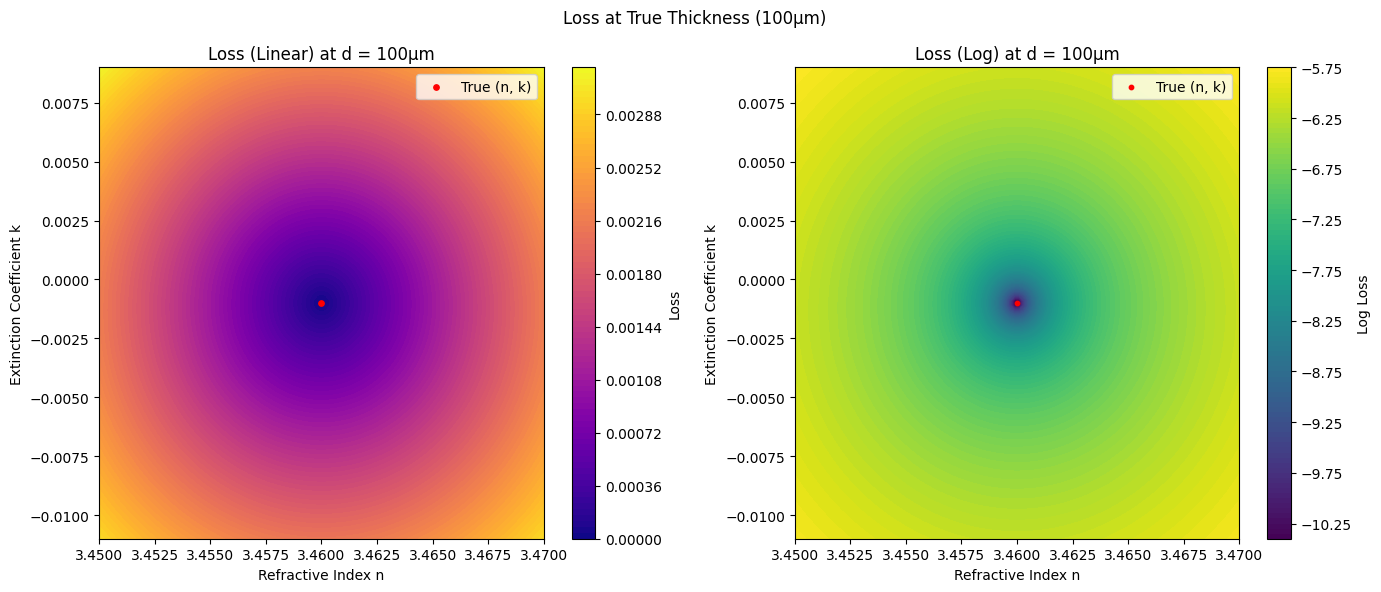

In [22]:
index = 2
true_d_loss_grid_log = loss_grids[index]
true_d_loss_grid = np.exp(true_d_loss_grid_log)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linear scale plot
c1 = axes[0].contourf(n_grid, k_grid, true_d_loss_grid, levels=100, cmap='plasma')
fig.colorbar(c1, ax=axes[0], label="Loss")
axes[0].scatter(n1, k1, color='red', label="True (n, k)", s=15)
axes[0].set_title(f"Loss (Linear) at d = {d_vals_microns[index]}µm")
axes[0].set_xlabel("Refractive Index n")
axes[0].set_ylabel("Extinction Coefficient k")
axes[0].legend()

# Log scale plot
c2 = axes[1].contourf(n_grid, k_grid, true_d_loss_grid_log, levels=100, cmap='viridis')
fig.colorbar(c2, ax=axes[1], label="Log Loss")
axes[1].scatter(n1, k1, color='red', label="True (n, k)", s=10, alpha=1)
axes[1].set_title(f"Loss (Log) at d = {d_vals_microns[index]}µm")
axes[1].set_xlabel("Refractive Index n")
axes[1].set_ylabel("Extinction Coefficient k")
axes[1].legend()
plt.suptitle('Loss at True Thickness (100µm)')
plt.tight_layout()
plt.show()


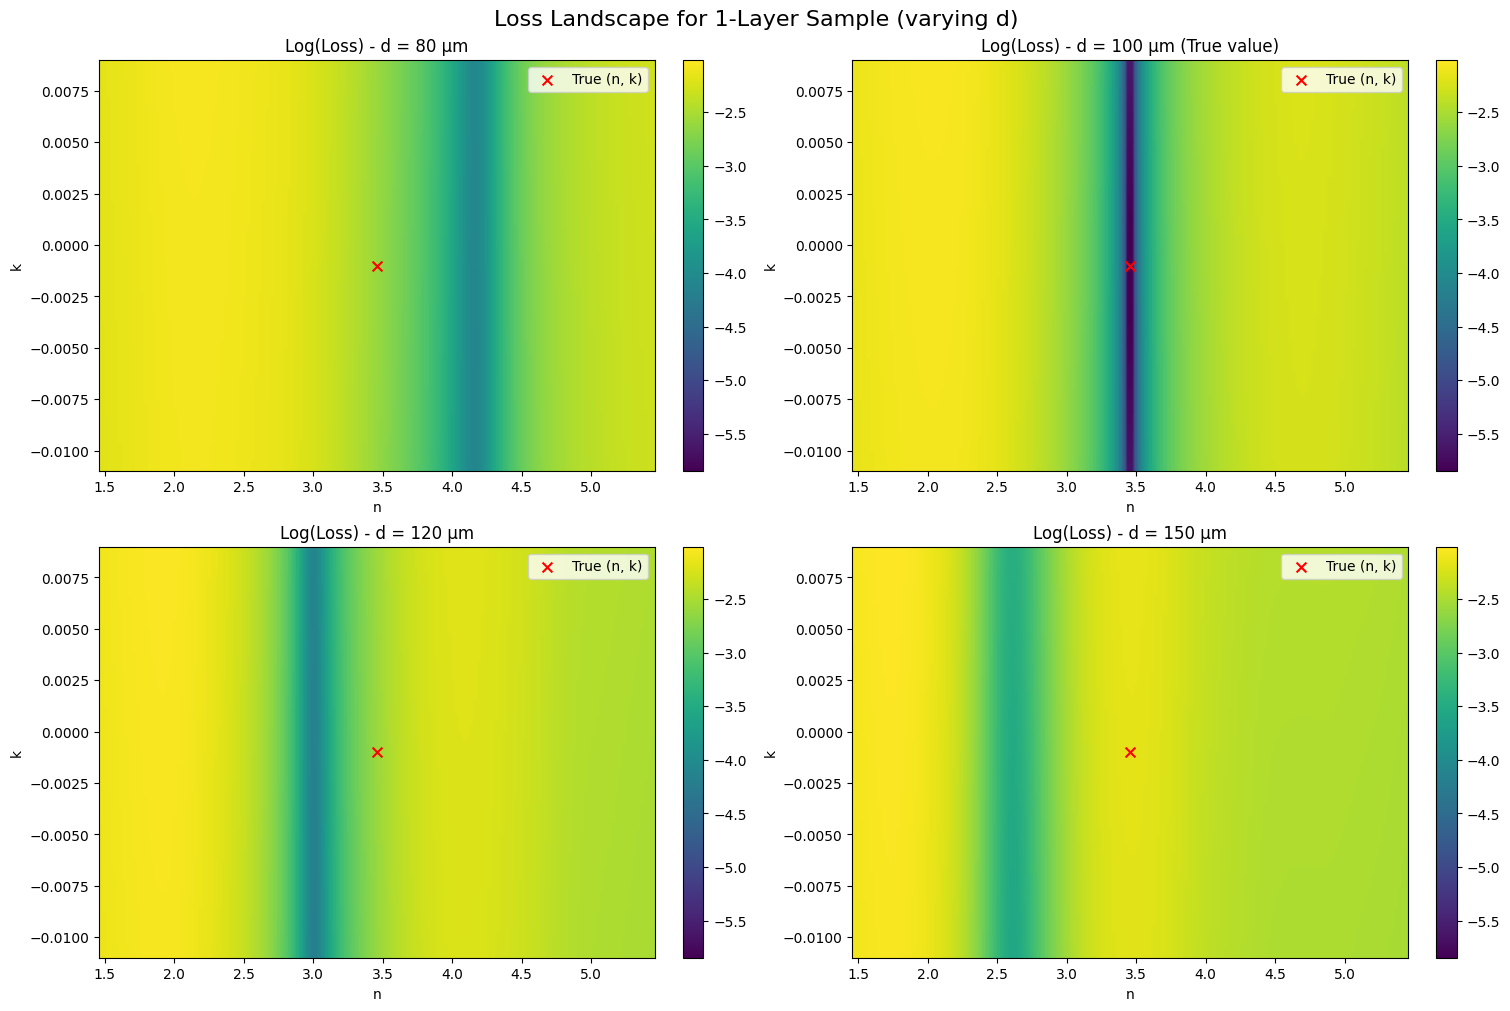

In [27]:
# Plotting
fig, axs = plt.subplots(2, int(len(d_vals_microns)/2), figsize=(15, 10), constrained_layout=True)
axs = axs.flatten()

for idx, (d_fixed_micron, loss_log) in enumerate(zip(d_vals_microns, loss_grids)):
    ax = axs[idx]
    
    im = ax.imshow(
        loss_log,
        extent=[n_vals[0], n_vals[-1], k_vals[0], k_vals[-1]],
        origin='lower',
        aspect='auto',
        cmap='viridis',
        vmin=vmin,
        vmax=vmax
    )
    
    # Check if this is the true thickness (allow for small floating point error)
    is_true_d = np.isclose(d_fixed_micron, d1 * 1e6, atol=1e-2)
    
    title = f"Log(Loss) - d = {d_fixed_micron} µm"
    if is_true_d:
        title += " (True value)"
    ax.set_title(title)

    ax.set_xlabel("n")
    ax.set_ylabel("k")
    
    # Plot true (n1, k1) as a red dot
    ax.scatter(n1, k1, color='red', marker='x', s=50, label='True (n, k)')
    ax.legend(loc='upper right')

    plt.colorbar(im, ax=ax)

plt.suptitle("Loss Landscape for 1-Layer Sample (varying d)", fontsize=16)
plt.show()